# Overview
In this notebook I will use a U-net like architecture for an instance segmentation problem. The challenge is to detect boats in satelite imagery. 

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [51]:
BATCH_SIZE = 2
NB_EPOCHS = 6
VALID_IMG_COUNT = 500
RESIZING = False
DIMENSIONS = (512, 512)
LEARNING_RATE = 0.01
TRAIN_ENCODER = False
CONTINUE_TRAINING = False

In [52]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
import gc
from skimage.morphology import label
gc.enable()  # memory is tight
%matplotlib inline

ship_dir = 'input'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')
model_dir = ''


def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels == k) for k in np.unique(labels[labels > 0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype=np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [53]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations.csv'))
print(masks.shape[0], 'masks found')
print('Total number of train images: {}'.format(masks['ImageId'].value_counts().shape[0]))
masks.head()

131030 masks found
Total number of train images: 104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


# Make sure encode/decode works
Given the process
$$  RLE_0 \stackrel{Decode}{\longrightarrow} \textrm{Image}_0 \stackrel{Encode}{\longrightarrow} RLE_1 \stackrel{Decode}{\longrightarrow} \textrm{Image}_1 $$
We want to check if/that
$ \textrm{Image}_0 \stackrel{?}{=} \textrm{Image}_1 $
We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.



Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


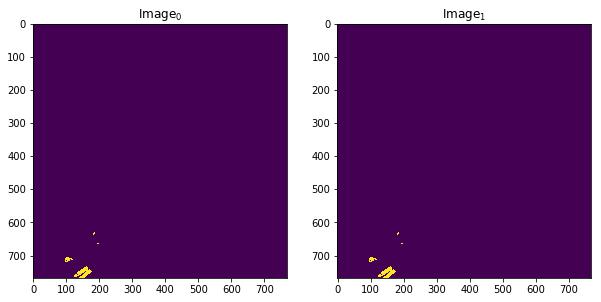

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

In [56]:
masks['numberShips'] = masks.EncodedPixels.map(lambda row: 1 if isinstance(row, str) else 0)

unique_img_ids = masks.groupby('ImageId').agg({'numberShips': 'sum'}).reset_index()
unique_img_ids['file_size_kb'] = (unique_img_ids['ImageId'].
                                  map(lambda c_img_id: 
                                os.stat(os.path.join(train_image_dir,
                                c_img_id)).st_size / 1024))
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50]  # keep only 50kb files to get rid of truncated file
unique_img_ids.head()


,ImageId,numberShips,file_size_kb
0,00003e153.jpg,0,128.944336
1,000155de5.jpg,1,147.625977
2,00021ddc3.jpg,9,242.910156
3,0002756f7.jpg,2,287.620117
4,0002d0f32.jpg,0,125.598633


In [57]:
masks.drop('numberShips', axis=1, inplace=True)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [ ]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, train_size=0.7,
                 test_size = 0.3, 
                 stratify = unique_img_ids['numberShips'],
                                        )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')


91008 training masks
39006 validation masks


## Get an overview of the number of ships in training dataset

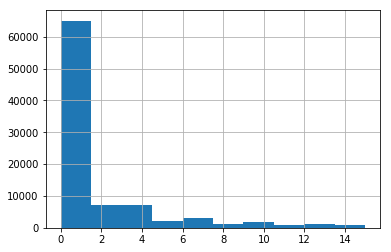

maximum number of ships: 15


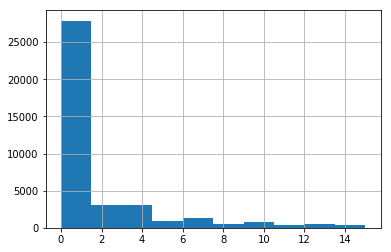

In [58]:
train_df['numberShips'].hist()
plt.show()
valid_df['numberShips'].hist()
train_df.head()
print('maximum number of ships: {}'.format(train_df.numberShips.max()))

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to segment

In [59]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(ratio={0: 1000, 1: 1500, 2: 1500,
                                3: 1200, 4: 1200, 5: 1200,
                                6: 1200, 7: 700, 8: 700,
                                9: 700, 10: 700, 11: 700,
                                12: 600, 13: 500, 14: 500,
                                15: 450})


In [60]:
x = np.array(train_df.ImageId).astype(np.str_).reshape(-1, 1)
y = np.array(train_df.numberShips).astype(np.uint8)

x_train, y_train = rus.fit_sample(x, y)



,ImageId,EncodedPixels
0,a60b35c62.jpg,NaN
1,b96ce3a53.jpg,NaN
2,fa1073b6e.jpg,NaN
3,5620a0611.jpg,NaN
4,990c368c5.jpg,NaN


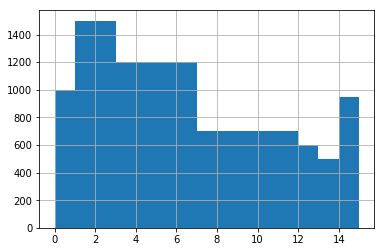

In [61]:
balanced_x = pd.DataFrame(x_train).rename({0: 'ImageId'}, axis=1)
train_masks = pd.merge(balanced_x, train_df)
balanced_x = pd.merge(balanced_x, unique_img_ids, how='left', on='ImageId')
balanced_x.numberShips.hist(bins=15)
train_masks = train_masks.drop(['numberShips', 'file_size_kb'], axis='columns')
train_masks.set_index('ImageId')
train_masks.head()


# Decode all the RLEs into Images
Building a generator to read in all images and masks. Also we do some resizing of the images to make the model less computational intensive

In [62]:
from skimage.transform import resize


def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            if RESIZING:
                c_img = resize(c_img, DIMENSIONS)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0), np.stack(out_mask, 0)
                out_rgb, out_mask = [], []


In [63]:
train_gen = make_image_gen(train_masks)

# Make the Validation Set

In [65]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(len(valid_x), valid_x.max(), valid_x.min())

500 255 0


# Augment Data

In [66]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

dg_args = dict(featurewise_center=False,
               samplewise_center=False,
               rotation_range=15,
               width_shift_range=0.1,
               height_shift_range=0.1,
               zoom_range=[0.8, 1.25],
               horizontal_flip=True,
               vertical_flip=True,
               fill_mode='reflect',
               data_format='channels_last',
               preprocessing_function=preprocess_input)

image_gen = ImageDataGenerator(**dg_args)
dg_args.pop('preprocessing_function')
mask_gen = ImageDataGenerator(**dg_args)


def create_aug_gen(in_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(in_x,
                             batch_size=BATCH_SIZE,
                             seed=seed)
        g_y = mask_gen.flow(in_y,
                            batch_size=BATCH_SIZE,
                            seed=seed)

        yield next(g_x), next(g_y)


In [67]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail


x (2, 768, 768, 3) float32 -113.404305 111.581535
y (2, 768, 768, 1) float32 0.0 1.0


In [68]:
gc.collect()

7

# Build a Model
Here we use a slight deviation on the U-Net standard

In [69]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy


def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)


def dice_p_bce(in_gt, in_pred):
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)


def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)


# IoU metric closer to competition metric
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1 - y_true, 1 - y_pred)  ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return -K.mean((intersection + eps) / (union + eps), axis=0)

In [70]:
from keras import models, layers
from keras.backend import tf as ktf
from keras.applications.vgg16 import VGG16 as VGG16
from keras.models import load_model

def get_model():
    if not CONTINUE_TRAINING:
        encode_model = VGG16(input_shape=t_x.shape[1:], include_top=False, weights='imagenet')
        encode_model.trainable = False

        # output and start upsampling
        features = encode_model.output
        conv_1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(features)
        up_conv = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv_1)

        # first concatenation block
        concat_1 = layers.concatenate([encode_model.get_layer('block5_conv3').output, up_conv], axis=-1,
                                      name='concat_1')
        conv_2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
        up_conv_2 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv_2)

        # second concatenation block
        concat_2 = layers.concatenate([up_conv_2, encode_model.get_layer('block4_conv3').output])
        conv_3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat_2)
        up_conv_3 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv_3)

        # third concatenation block
        concat_3 = layers.concatenate([up_conv_3, encode_model.get_layer('block3_conv3').output])
        conv_4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat_3)
        up_conv_4 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv_4)

        # fourth concatenation block
        concat_4 = layers.concatenate([up_conv_4, encode_model.get_layer('block2_conv2').output])
        conv_5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv')(concat_4)
        up_conv_5 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv_5)

        # fifth concatenation block
        concat_4 = layers.concatenate([up_conv_5, encode_model.get_layer('block1_conv2').output])
        out = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(concat_4)

        # Scaling to original dimensions
        if RESIZING:
            out = layers.Lambda(lambda image: ktf.image.resize_images(image, (768, 768)))(conv_6)

        if not TRAIN_ENCODER:
            # keep Imagenet weights for VGG16 encoder
            for layer in encode_model.layers:
                layer.trainable = False

        model = models.Model(inputs=[encode_model.input], outputs=[out])
        model.summary()
        return model
    else:
        pt_model = load_model(model_dir,
                              custom_objects={'dice_p_bce': dice_p_bce,
                                              'dice_coef': dice_coef,
                                              'true_positive_rate': true_positive_rate,
                                              'IoU': IoU})
        return pt_model


In [71]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

def get_callbacks():
    weight_path = "{}_weights.best.hdf5".format('seg_model')
    
    checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                                 save_best_only=True, mode='min', save_weights_only=True)
    
    tensorboard = TensorBoard("./logs", write_images=False)
    
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                       patience=3,
                                       verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
    
    return [checkpoint, reduceLROnPlat, tensorboard]


In [72]:
model = get_model()
callbacks = get_callbacks()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 768, 768, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 768, 768, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 384, 384, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [73]:
model.compile(optimizer=Adam(LEARNING_RATE, decay=LEARNING_RATE / NB_EPOCHS), loss=IoU,
              metrics=[dice_coef, 'binary_accuracy',
                       true_positive_rate])


def fit():
    step_count = (balanced_x.shape[0] // BATCH_SIZE) // NB_EPOCHS
    aug_gen = create_aug_gen(make_image_gen(train_masks.sample(frac=1)))
    loss_history = [model.fit_generator(aug_gen,
                                        epochs=NB_EPOCHS,
                                        steps_per_epoch=step_count,
                                        validation_data=(valid_x,
                                                         valid_y),
                                        callbacks=callbacks,
                                        workers=1,
                                        verbose=2)]
    return loss_history


counter = 0

while True:
    loss_history = fit()
    print('Training epoch {}'.format(counter))
    counter += 1
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.8 or counter == 5:
        break


Epoch 1/6


In [ ]:
model.load_weights(weight_path)
model.save('segmentation_model_final.h5')